# Sentiment Analysis With BERT

In this notebook, we will use the pre-trained model BERT (Bidirectional Encoder Representations from Transformers) to preform sentiment analysis. We will use this model to analyze restaurant reviews and visualize the results of reviews from [Bouchon Bakery](https://www.thomaskeller.com/bouchonbakeryyountville) in Las Vegas, NV. This is a modified dataset sourced from Kaggle titled [“Yelp Restaurant Reviews”](https://www.kaggle.com/datasets/farukalam/yelp-restaurant-reviews) by Faruk Alam (April 2022).


Reading a single review to determine whether it’s positive or negative is simple. But what if you were asked to analyze thousands upon thousands? That would quickly become overwhelming! This is where sentiment analysis steps in. Sentiment analysis is the process of using NLP (natural language processing) and machine learning models to determine the emotional tone expressed in a piece of text efficiently. Now, instead of sifting through review after review, you can simply upload a file, and within minutes, receive a sentiment for each piece of text.

By classifying sentiment in text, businesses and analysts gain valuable insights into customer feedback, making it easier to identify trends and make data-driven decisions. For our analysis, we will be using the [Google BERT model & built-in tokenizer.](https://arxiv.org/pdf/1810.04805)

Let's dive in!

# Step One - Import Necessary Libraries

In [ ]:
# Ignoring warnings.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from tqdm.auto import tqdm
import nltk

# Stop words library.
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Library with our pre-trained model.
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Libraries we will access later for creating visualizations.
from wordcloud import WordCloud
import matplotlib.pyplot as plt

We will begin by importing the necessary libraries for this program. For this program, we will use Pandas, Transformers, and TQDM. The Pandas library is used to convert our data from a CSV (comma-separated values) file to a table format.
The TQDM (pronounced taqadum which means 'progress' in Arabic) allows us to easily create progress bars and visually monitor the progress. This bar will be especially useful during text classification. Lastly, the Transformers library provides tools to load and use pre-trained models. I also went ahead and imported our data visualization libraries that we will tackle later.

# Step Two: Load and Preprocess Data

Due to the sheer number of reviews, I transformed the data in these ways:


*   Dropped rows with empty reviews.
*   Ignored warnings (In our case, the warnings should be fine and run without error).
*   Filtered the data to only use reviews from the most recent year in the dataset: 2022.
*   Extracted the data and focused on three fields: date, rating, and review.


 I did this to decrease processing time and keep the data relevant. Classifying 20,000 reviews takes a while for even a fast computer; 2,000 is more manageable.

In [ ]:
# Read in the data.
reviews = pd.read_csv("/content/yelp_reviews_bouchon_bakery_las_vegas.csv") #The file path can be replaced.

# Filter for the years 2023 and 2024, using .loc to avoid the SettingWithCopyWarning
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
reviews = reviews.loc[(reviews['date'].dt.year == 2022)].copy()

# Dropping rows with empty reviews
reviews = reviews.dropna(subset=["review"])

reviews
# Loads the CSV file into a DataFrame and display its contents.

,date,rating,review
0,2022-01-22,5,All I can say is they have very good ice cream...
1,2022-06-26,4,Nice little local place for ice cream.My favor...
26,2022-04-20,5,Pro-tip: Definitely give the rotating ice crea...
27,2022-07-18,3,After seeing some positive reviews about Rewin...
28,2022-07-13,3,I got the special! Orange creamsicle flavored ...
...,...,...,...
19878,2022-02-18,5,"We dropped by because of Lavazza, but we're in..."
19879,2022-07-10,5,"wow, we were all attracted by their authentic ..."
19880,2022-02-13,4,I stopped by La Pasticceria to get a bite to e...
19884,2022-03-02,5,The cream puffs and the fruit tarts are my fav...


Let's see what the data tells us without preprocessing!

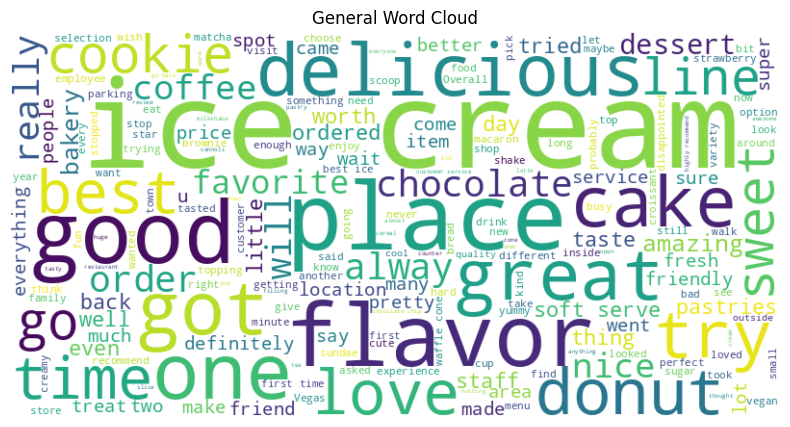

In [ ]:
all_comments = ' '.join(reviews['review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("General Word Cloud")
plt.show()

Hmm. This word cloud does not look quite right. It is a jumble of words. The highest occurring words are "ice cream", "flavor", and "delicious", which are great! But there are some other ones like "try", "place", and "got". These words don't tell us anything! These words, which don’t add meaning or provide insight, are called stop words. Our next step will be to filter out these stop words.

In [ ]:
tqdm.pandas(desc="Classifying" ) #Applying the progress bar

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

reviews['review'] = reviews['review'].progress_apply(remove_stopwords)

Classifying:   0%|          | 0/1138 [00:00<?, ?it/s]

Great! Now that we have filtered out the data, let's take a look at our updated word cloud.

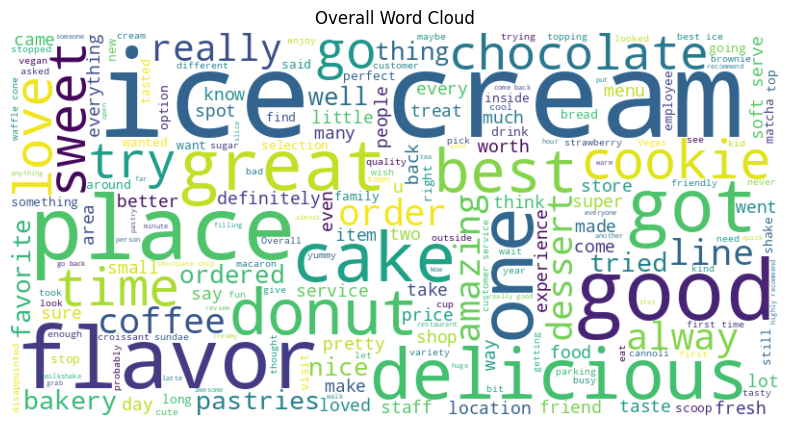

In [ ]:
all_comments = ' '.join(reviews['review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Overall Word Cloud")
plt.show()

This cloud gives us slightly more insight that the previous one. We can now figure out what people are generally saying about the restaurant. But let’s apply some sentiment analysis to capture what people are *feeling*.

# Step 3: Classifying

Now that we have all of our necessary tools, lets begin classifying!

We will begin by loading in the BERT model and tokenizer from the Transformers library.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("karimbkh/BERT_fineTuned_Sentiment_Classification_Yelp") # Breaks down text into tokens.
model = AutoModelForSequenceClassification.from_pretrained("karimbkh/BERT_fineTuned_Sentiment_Classification_Yelp") #Pre-trained model that will classify the sentiment of each text.
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer) # Combining the tokenizer and model

The first model is the tokenizer, which breaks down text into tokens, the individual pieces of a text. The model is the pre-trained model that will classify the sentiment of each token. The pipe combines the tokenizer and model into a pipeline, making it a one-stop shop for inputting text and getting sentiment analysis results.

Now, using the pipeline that we built, we can pass our "Comment" column from the dataframe through the pipeline to get the overall sentiment value for each comment. It adds a new column titled "sentiment," where each comment is labeled with either "positive" or "negative" sentiment.








In [ ]:
tqdm.pandas(desc="Classifying" ) #Applying the progress bar

#
def label(label):
    return "positive" if label == "LABEL_1" else "negative"

def classify_text(text):
    result = pipe(text[:512])[0]['label']
    return label(result)

reviews['sentiment'] = reviews['review'].progress_apply(classify_text)


Classifying:   0%|          | 0/1138 [00:00<?, ?it/s]

Note: The pipeline's default labels are "LABEL_0" for negative and "LABEL_1" for positive sentiment. I created a labeling function that takes these labels and assigns the sentiment as "negative" or "positive" instead.

We can now save the new data with the sentiment labels into a separate file.

In [ ]:
sentiment_reviews.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')
reviews.to_csv('SentimentAnalysis_BouchonBakery.csv')

In [ ]:
sentiment_reviews = pd.read_csv('/content/SentimentAnalysis_BouchonBakery.csv') # Read in the new file.
sentiment_reviews # Displays the new dataframe with the labeled sentiment attatched.

,date,rating,review,sentiment
0,2022-01-22,5,say good ice cream would sure recommend cookie...,positive
1,2022-06-26,4,Nice little local place ice cream.My favorite ...,positive
2,2022-04-20,5,Pro-tip: Definitely give rotating ice cream fl...,positive
3,2022-07-18,3,"seeing positive reviews Rewind, wanted stop ch...",positive
4,2022-07-13,3,got special! Orange creamsicle flavored soft s...,positive
...,...,...,...,...
1133,2022-02-18,5,"dropped Lavazza, we're intrigued La Pasticceri...",positive
1134,2022-07-10,5,"wow, attracted authentic Italian pastries sele...",positive
1135,2022-02-13,4,stopped La Pasticceria get bite eat breakfast....,positive
1136,2022-03-02,5,"cream puffs fruit tarts favorite, cookies must...",positive


We have now labeled each review with its corresponding sentiment—score! But what does it reveal? Let’s create some visualizations to help us understand the newfound data.

# Step 4: Data Visualizations

Data visualizations are graphical representations of data that make complex information easier to understand, helping to identify patterns, trends, and insights at a glance.

### Visualization One: Bar Graph



The first plot we will create is a bar graph to demonstrate the total number of positive and negative reviews from the most recent year.

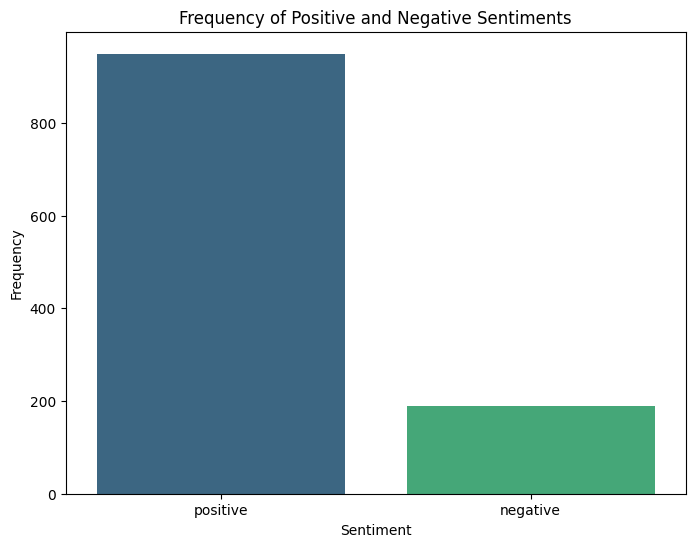

In [ ]:
# prompt: frequency bar graph of posititve/ negative words

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'sentiment_reviews' DataFrame is already loaded as in your provided code.
# If not, load it here:
# sentiment_reviews = pd.read_csv('/content/SentimentAnalysis_BouchonBakery.csv')


# Create the frequency bar graph
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.countplot(x='sentiment', data=sentiment_reviews, palette='viridis') # Use a suitable color palette
plt.title('Frequency of Positive and Negative Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

#### What does this tell us?

The x-axis represents the positive and negative reviews. The y-axis represents the total number of occurrences of positive/negative reviews. The positive sentiment has a higher count, with over 800 instances, while the negative sentiment has fewer than 200. The bakery is doing well! Over the past year, they’ve received overwhelmingly more positive reviews than negative ones.

### Visualization 2: Word Clouds

Our next visualization will be word clouds. In word clouds, the size of each word indicates its frequency or importance in the dataset. The bigger the word, the more frequent it appears across comments and vice versa. Data visualizations provide a quick, at-a-glance overview of keywords.

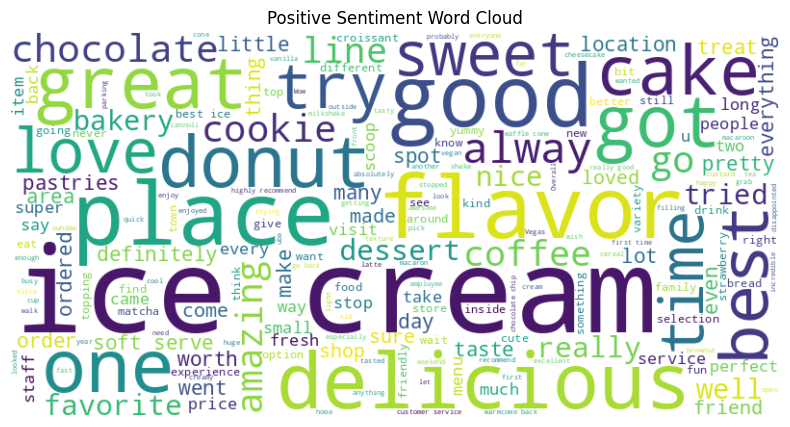

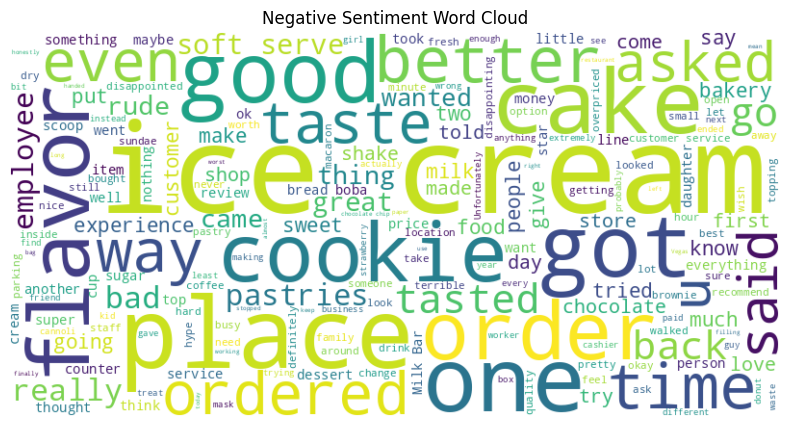

In [ ]:
# Grouping the words into their respective positive/negative groups
positive_comments = ' '.join(reviews[reviews['sentiment'] == 'positive']['review'])
negative_comments = ' '.join(reviews[reviews['sentiment'] == 'negative']['review'])

# Generate the word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_comments)

# Display positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Sentiment Word Cloud")
plt.show()

# Display negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Sentiment Word Cloud")
plt.show()

#### What does this tell us?


"Ice cream" and "place" appear frequently between the two word clouds—seems like what they’re best known for is also where they get the most complaints.

Looking at the negative word cloud, the other top words are "flavor," "asked," "tasted," "order," and "time." These words hint that there may be room for improvement in taste, order accuracy, and wait times.

Now, looking at the positive word cloud, words like "food," "love," "chocolate," and "love" appear prominently. "Good," "always," and "great" indicate overall satisfaction with the experiences described. These top words suggest that people often mention the bakery positively. Also, maybe the bakery should focus on ice cream and cake!




### Visualization Three: Violin Plot

A violin plot is a way to visualize the distribution of sentiment across the different ratings. The wider the "violin," the higher the number of reviews with that sentiment labeled at that rating. The white dot represents the median, and the thick black bar represents the middle 50% of the data. We will use this plot to visualize the relationship between sentiment and the rating score.

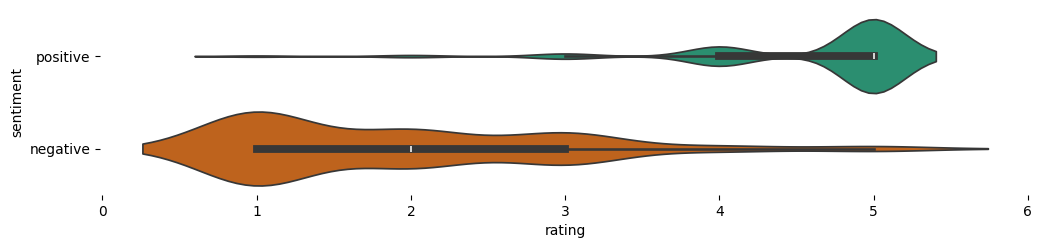

In [ ]:
figsize = (12, 1.2 * len(sentiment_reviews['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(sentiment_reviews, x='rating', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#### What does this tell us?

The x-axis represents the rating from 1 to 5. The y-axis represents the positive/negative sentiment. Although the shape of our violins is a little morphed, we can observe that there is a positive correlation between sentiment and rating. This aligns with what we would expect—satisfied customers give better ratings. We can also see that the negatively marked reviews have a wider range of ratings. While most negative reviews might have lower ratings, some might still have relatively higher scores. This could be due to customers having mixed experiences or higher expectations.

## Visualization Four: Stacked Bar Plot

Our last visualization will be a stacked bar plot across the most recent 8-month period. This plot will allow us to see what percentage of positive/negative reviews contribute to the total reviews for each month.

<Figure size 1200x600 with 0 Axes>

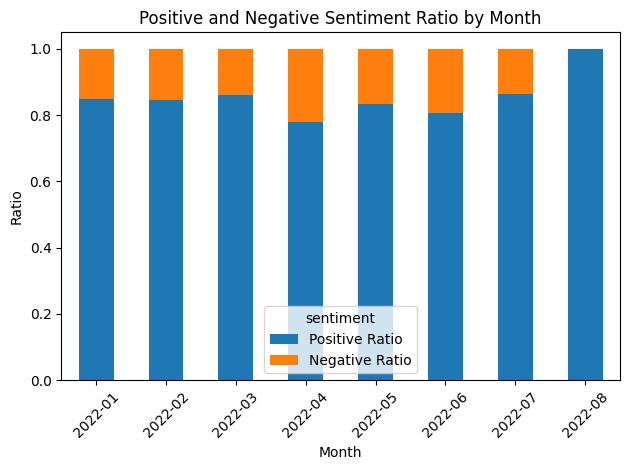

In [ ]:
# Group by month and sentiment, then count occurrences
monthly_sentiment = sentiment_reviews.groupby([sentiment_reviews['date'].dt.to_period('M'), 'sentiment']).size().unstack(fill_value=0)

# Calculate the ratio of positive to negative sentiment for each month
monthly_sentiment['Positive Ratio'] = monthly_sentiment['positive'] / (monthly_sentiment['positive'] + monthly_sentiment['negative'])
monthly_sentiment['Negative Ratio'] = monthly_sentiment['negative'] / (monthly_sentiment['positive'] + monthly_sentiment['negative'])

# Plotting
plt.figure(figsize=(12, 6))
monthly_sentiment[['Positive Ratio', 'Negative Ratio']].plot(kind='bar', stacked=True)
plt.title('Positive and Negative Sentiment Ratio by Month')
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The x-axis in this bar chart represents the months from January 2022 to August 2022, and the y-axis shows the ratio of sentiment. Each month has a stacked bar divided into two sections: the blue portion represents the Positive Ratio, and the orange portion represents the Negative Ratio.

A lot of blue is great! Although the ratio is predominantly positive across all months in the most recent year, there is a consistent portion of negative sentiment over time. However, in the last month (August 2022), there are no negative reviews, which indicates that August must have been a smooth ride.

## Step Five: Conclusion

The sentiment analysis revealed that Bouchon Bakery has a generally positive customer perception in their written reviews. Ice cream and cakes seem to be favored offerings (they should consider shifting their focus into an ice cream shop), while some areas like order accuracy and wait times may require attention.

By consistently monitoring customer sentiment, Bouchon Bakery can identify areas for improvement and maintain its positive reputation. This approach allows businesses to leverage customer feedback for data-driven decision-making and service improvement.